## Sentinel-2 Image (Dataset Availability: 2015-06-27 to Present)
### [Sentinel-2 Earth Engine Documentation](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED)

In [ ]:
# Install necessary packages
!pip install earthengine-api geemap google-cloud-storage
!pip install cartopy
!pip install matplotlib

# Import libraries
import ee
import geemap
from google.cloud import storage
from google.colab import files

ee_project = 'ee-project-earthengine'

# Authenticate and initialize Earth Engine
def authenticate_and_initialize():
    """
    Authenticates and initializes Google Earth Engine with the specified project.
    """
    # Revoke previous authentication if any
    !earthengine authenticate --revoke

    # Authenticate user; follow the link, log in, and enter the code
    ee.Authenticate()

    # Initialize the Earth Engine API with the specific Google Cloud project
    ee.Initialize(project= ee_project)

authenticate_and_initialize()

# Test accessing Google Cloud Storage
def test_gcs_access():
    """
    Tests access to Google Cloud Storage and lists all buckets in the project.
    """
    try:
        # Create a Cloud Storage client with the project ID
        client = storage.Client(project= ee_project)

        # List all buckets in the project
        buckets = list(client.list_buckets())
        print("Buckets:")
        for bucket in buckets:
            print(bucket.name)
    except Exception as e:
        print("Error accessing Google Cloud Storage:", e)

test_gcs_access()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.1 MB/s eta 0:00:00
E0000 00:00:1756348687.776959    1238 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756348687.784300    1238 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756348687.803862    1238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756348687.803912    1238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1756348687.803916    1238 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [ ]:
%%capture
!pip install pyproj
!pip install cartoee
!pip install pycrs
!pip install geopandas

In [ ]:
# Adding an interactive map.
Map = geemap.Map(basemap='ROADMAP', center=[24, 91], zoom=7, height=600, draw = True)

# Adding the TERRAIN basemaps.
Map.add_basemap("Esri.WorldImagery")
Map

Map(center=[24, 91], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [ ]:
# import geopandas as gpd

# gdf = gpd.read_file(r"/content/Shape_File/Study_Area_Bhabodaho_and_Beel_Dakatia_UTM.shp")

# # Convert to ee.FeatureCollection
# feature = geemap.gdf_to_ee(gdf)

# # Getting the geometry
# AOI = feature.geometry()

# # Define the AOI.
# Map.addLayer(AOI, {}, "AOI")
# Map.centerObject(AOI, 10)
# Map

Map(bottom=7417.0, center=[22.973004912721187, 89.29268829855256], controls=(WidgetControl(options=['position'…

In [ ]:
# Taking a draw feature from the map.
feature = Map.draw_last_feature

# If drawing does not exist then taking a polygon as the default version.
if feature is None:
    geom = ee.Geometry.Polygon([[[88.883868, 25.146205],
                                 [89.7391, 25.146205],
                                 [89.7391, 26.25199],
                                 [88.883868, 26.25199],
                                 [88.883868, 25.146205]]])
    feature = ee.Feature(geom, {})

# Define the AOI.
AOI = feature.geometry()
Map.addLayer(AOI, {}, "AOI")
Map

Map(bottom=14433.0, center=[24, 91], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [ ]:
# Function to mask clouds using the Sentinel-2 SCL band.
def S2CloudMaskSCL(img):
    qa = img.select('SCL')
    mask_band = qa.eq(3).Or(qa.eq(8)).Or(qa.eq(9)).Or(qa.eq(10)).Or(qa.eq(11))
    mask = mask_band.eq(0)
    # Return the masked and scaled data.
    return img.updateMask(mask)

def ESAcloudMask(img):
    ''' Sentinel-2 Bits 10 & 11 are clouds & cirrus, so set to 0. '''
    qa = img.select('QA60')
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    clear = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    return img.updateMask(clear)

In [ ]:
start_date = '2024-10-01'
end_date = '2024-10-31'

In [ ]:
#  Filter Sentinel2 collection and apply the cloud mask.
clound_masked = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterDate(start_date, end_date)
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                      .filterBounds(AOI)
                      .map(S2CloudMaskSCL)
                      .map(ESAcloudMask))

In [ ]:
# Without cloud masking
sentinel_2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                      .filterDate(start_date, end_date)
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                      .filterBounds(AOI))

In [ ]:
print ('Number of Sentinel-2 images:', sentinel_2_collection.size().getInfo())

Number of Sentinel-2 images: 20


In [ ]:
# Specify visualization parameters.
vis_natural = {
    'bands': ['B8', 'B4', 'B3'],
    'min': 0.0,
    'max': 3000,
}

vis_nir = {
    'bands': ['B12', 'B8A', 'B4'],
    'min': 0.0,
    'max': 3000,
}

# Generate Earth Engine layers.
left_layer = geemap.ee_tile_layer(sentinel_2_collection.first(), vis_natural,  'with cloud')
right_layer = geemap.ee_tile_layer(clound_masked.first(), vis_nir, 'without cloud')

# Create a split-panel map.
Map_S2 = geemap.Map(height=600)
Map_S2.split_map(left_layer, right_layer)
Map_S2.centerObject(sentinel_2_collection, 8)
Map_S2

Map(center=[25.4329797990785, 89.25981372341704], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [ ]:
# Creating a cloud masked median image
S2_masked_median = clound_masked.median().clip(AOI)

# Vis paramateres
vis_s2 = {"min":0, "max":3000,"bands": ['B11', 'B8', 'B2']}

Map_all = geemap.Map(height=500)
Map_all.centerObject(S2_masked_median, 10)
Map_all.addLayer(S2_masked_median, vis_s2, 'Sentinel-2 median')
Map_all

Map(center=[25.698865041182394, 89.3114839999997], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
# Create an NDWI image, define visualization parameters and display.
ndwi = S2_masked_median.normalizedDifference(['B3', 'B8'])
ndwiViz = {'min': -0.6, 'max': 0.5, 'palette': ['FFFFFF', '1637f1']} # 44c9f1

Map_ndwi = geemap.Map(height=500)
Map_ndwi.centerObject(ndwi, 10)
Map_ndwi.addLayer(ndwi, ndwiViz, 'NDWI', True)
Map_ndwi

Map(center=[22.973004912721187, 89.29268829855256], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Create an NDWI image, define visualization parameters and display.
ndwi = S2_masked_median.normalizedDifference(['B3', 'B8'])
ndwiViz = {'min': -0.8, 'max': 0.8, 'palette': ['#008000', '#FFFFFF', '#0000CC']} # [Green, White, Blue]

Map_ndwi = geemap.Map(height=600)
Map_ndwi.centerObject(ndwi, 10)
Map_ndwi.addLayer(ndwi, ndwiViz, 'NDWI', True)

#Adding Sentinel-2 Median Image
# Vis paramateres
vis_s2 = {"min":0, "max":1500,"bands": ['B4', 'B3', 'B2']}

Map_ndwi.addLayer(S2_masked_median, vis_s2, 'Sentinel-2 median')

Map_ndwi

Map(center=[22.973004912721187, 89.29268829855256], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
ndvi = S2_masked_median.normalizedDifference(['B8','B4'])
ndviViz = {'min': -0.9,'max': 0.5, 'palette': ['#e41a1c','#4daf4a','#ffff99','#386cb0', '#1637f1']}

Map_ndvi = geemap.Map(height=800)
Map_ndvi.centerObject(ndvi, 10)
Map_ndvi.addLayer(ndwi, ndviViz, 'NDWI', True)
Map_ndvi

Map(center=[22.973004912721187, 89.29268829855256], controls=(WidgetControl(options=['position', 'transparent_…

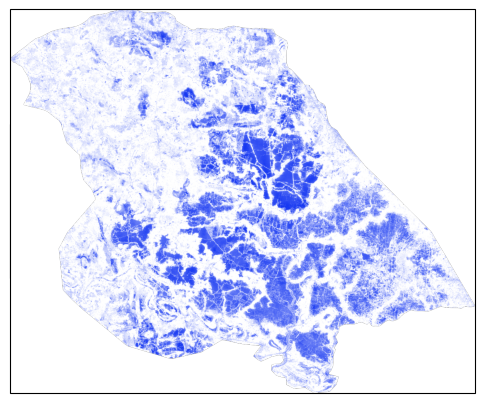

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from geemap import cartoee

# Create an NDWI image, define visualization parameters, and display.
ndwi = S2_masked_median.normalizedDifference(['B3', 'B8'])
ndwiViz = {'min': -0.6, 'max': 0.5, 'palette': ['FFFFFF', '1637f1']}

# Apply the visualization parameters to the NDWI image
ndwi_vis_image = ndwi.visualize(min=ndwiViz['min'], max=ndwiViz['max'], palette=ndwiViz['palette'])

minlon, maxlon, minlat, maxlat = (89.351801, 89.596964, 22.485893, 22.66469)

font={'family':'Times New Roman',
             'weight':'normal',
             'size':12}

plt.rc('font',**font)

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6, 12))

img_ax = plt.subplot(121, projection=ccrs.PlateCarree())
img_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)


img_ax = cartoee.get_map(ndwi, vis_params=ndwiViz, zoom_level=11)

# Save the figure as a JPG file
# plt.savefig('4_January_2025.jpg', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
# # Exporting the NDWI Image as TIFF File

# # Visualization parameters
# ndwi_viz = {
#     'min': -0.8,
#     'max': 0.8,
#     'palette': ['#008000', '#FFFFFF', '#0000CC']  # Green, White, Blue
# }


# # Export the image to Google Drive
# export = ee.batch.Export.image.toDrive(
#     image= ndwi.visualize(**ndwi_viz),  # Apply visualization parameters for RGB export
#     description='Study_Area_S2_NDWI_November_2024',
#     folder='NDWI_Image',              # Change as needed
#     fileNamePrefix='Study_Area_S2_NDWI_November_2024',
#     region=AOI,
#     scale=10,                          # Sentinel-2 has 10m resolution for B3 and B8
#     crs='EPSG:32645',                  # UTM Zone 45N
#     fileFormat='GeoTIFF',
#     maxPixels=1e13
# )

# # Start the export
# export.start()

In [ ]:
# Export the data to your google drive
task = ee.batch.Export.image.toDrive(
            image = S2_masked_median.select('B11', 'B8', 'B2').uint16(),
            description = 'Ghagot_Sentinel_2_Median_October_2024',
            folder = 'Sentinel_Image_2024',
            scale = 10,
            maxPixels = 10e12,
            fileDimensions= 256*2*100,
            shardSize= 256*2,
            crs = 'EPSG:4326',
            fileFormat='GeoTIFF',
            formatOptions = {'cloudOptimized': True})

task.start()